# Assignment 1
Name: Vo, Huynh Quang Nguyen

CWID: A20446163

In [1]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

### Problem 1
Note: I used the Euclidean distance $d = \sqrt{(x_0 - x_1)^2 + (y_0 - y_1)^2} = \sqrt{(dx)^2 + (dy)^2}$ as a metric to implement my kDTree.

In [2]:
def Euclidean_distance(p1, p2):
    """
    Compute the Euclidean distance between two points.
    """
    dx = p1[:,0] - p2.reshape((-1, p1.shape[1]))[:,0]
    dy = p1[:,1] - p2.reshape((-1, p1.shape[1]))[:,1]
    return np.sqrt(dx * dx + dy * dy)

def best_point(pt, p1, p2):
    """
    Compare a user-defined point with two reference points, and select whichever reference point is the nearest.
    """
    if p1 is None:
        return p2.reshape((-1, pt.shape[1]))

    if p2 is None:
        return p1.reshape((-1, pt.shape[1]))
    else:
        d1 = Euclidean_distance(pt, p1)
        d2 = Euclidean_distance(pt, p2)
        if d1 < d2:
            return p1.reshape((-1, pt.shape[1]))
        else:
            return p2.reshape((-1, pt.shape[1]))


def kdtree(data, depth = 0):
    """
    Construct a kDTree.
    """
    n_samp = data.shape[0]
    if n_samp != 0:
        axis = depth % data.shape[1]
        sort_data = data[data[ : , axis].argsort()]

        return {'point': sort_data[n_samp // 2,:],
             'left': kdtree(sort_data[ : n_samp // 2, : ], depth+1),
            'right': kdtree(sort_data[n_samp // 2 + 1:, : ], depth+1)}


def search_nearest_neighbor(kd, pt, depth = 0):

    if kd is not None:
        axis = depth % pt.shape[1]

        next_branch     = None
        opposite_branch = None

        if pt[:,axis] < kd['point'][axis]:
            next_branch     = kd['left']
            opposite_branch = kd['right']
        else:
            next_branch     = kd['right']
            opposite_branch = kd['left']

        best = best_point(pt, search_nearest_neighbor(next_branch, pt, depth + 1), kd['point'])
        if Euclidean_distance(pt, best) > (pt[:,axis] - kd['point'][axis]):
            best = best_point(pt, search_nearest_neighbor(opposite_branch, pt, depth + 1), best)

        return best

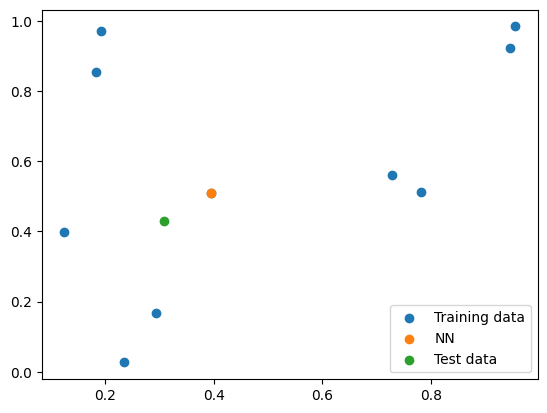

In [3]:
##
# Create a small dataset to test the recently created kD algorithm:
#
seed = 28
np.random.seed(seed)

X = np.random.rand(10, 2)
Y = np.random.rand(1, 2)

##
# Test the recently created kD algorithm
#
tree = kdtree(X)
nn = search_nearest_neighbor(tree, Y)

fig, axs = plt.subplots()
axs.scatter(x = X[ : , 0], y = X[ : , 1], label = 'X')
axs.scatter(nn[ : , 0], nn[ : , 1], label = 'NN')
axs.scatter(Y[ : , 0], Y[ : , 1], label = 'Y' )
axs.legend()
plt.show()

### Problem 2
Note: in this problem, I tried to get the same result as in the given example (in Figure 1).

(10000, 2)
(10000,)


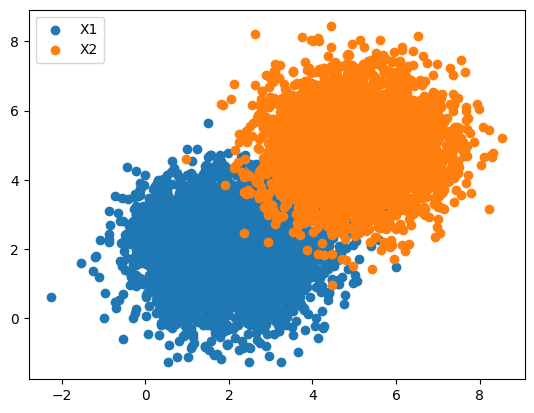

In [4]:
##
# Construct matrix X:
#
mean_X1 = (2,2)
cov_X1 = np.array([[1, 0], [0, 1]])
X1 = np.random.multivariate_normal(mean_X1, cov_X1, size = 5000)

mean_X2 = (5,5)
cov_X2 = np.array([[1, 0], [0, 1]])
X2 = np.random.multivariate_normal(mean_X2, cov_X2, size = 5000)

X = np.concatenate((X1,X2), axis = 0)

##
# Construct matrix Y:
#
Y1 = np.zeros(X1.shape[0])
Y2 = np.ones(X2.shape[0])

Y = np.concatenate((Y1, Y2), axis = 0)

##
# Sanity check:
#
print(X.shape)
print(Y.shape)

fig, axs = plt.subplots()
axs.scatter(x = X1[ : , 0], y = X1[ : , 1], label = 'X1')
axs.scatter(x = X2[ : , 0], y = X2[ : , 1], label = 'X2')
axs.legend()
plt.show()

(8057, 2)
(1943, 2)


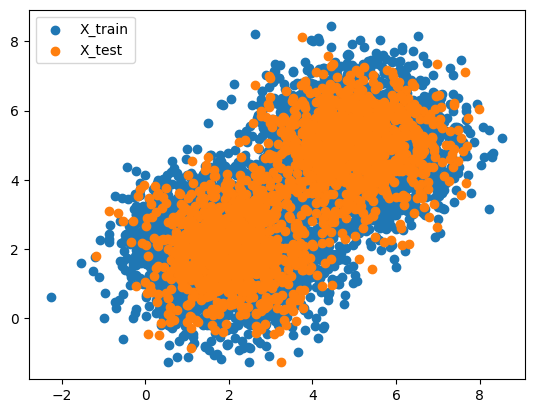

In [5]:
##
# Partition X and Y into training and test sets:
#
cutoff = 0.8
mask = np.random.rand(X.shape[0]) < cutoff
X_train = X[mask]
X_test = X[np.logical_not(mask)]

Y_train = Y[mask]
Y_test = Y[np.logical_not(mask)]

##
# Sanity check
#
print(X_train.shape)
print(X_test.shape)
fig, axs = plt.subplots()
axs.scatter(x = X_train[ : , 0], y = X_train[ : , 1], label = 'X_train')
axs.scatter(x = X_test[ : , 0], y = X_test[ : , 1], label = 'X_test')
axs.legend()
plt.show()

### Problem 3

In [6]:
def LLS(X,Y):
    """
    Construct the maximum-likelihood linear least squares function (Y = beta * X).
    """
    X_T = np.transpose(X)
    beta = np.dot(np.dot(np.linalg.inv(np.dot(X_T, X)), X_T), Y)
    return beta

def LLS_classify(X, beta, threshold: float):
    """
    Classify the elements of a set using the linear least square function with a threshold.
    """
    Yhat = np.dot(X, beta)
    Yhat = np.where(Yhat < threshold, 0, 1)
    return Yhat

def get_elements_from_training_set(X_train, Y_train, class_Y: int):
    """
    Get training set elements from a user-defined class.
    """
    return X_train[Y_train == class_Y, :]

def get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, class_Y: int):
    """
    Get correctly classified test set elements from a user-defined class.
    """
    class_corrected = []
    for i in range(0, Y_test.shape[0]):
        if Y_test[i] == class_Y:
            if Yhat_test[i] == Y_test[i]:
                class_corrected.append(i)

    return X_test[class_corrected, :]

def get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, class_Y: int):
    """
    Get incorrectly classified test set elements from a user-defined class.
    """
    class_incorrected = []
    for i in range(0, Y_test.shape[0]):
        if Y_test[i] == class_Y:
            if Yhat_test[i] != Y_test[i]:
                class_incorrected.append(i)

    return X_test[class_incorrected, :]

def compute_classifier_accuracy(X, Y, Yhat):
    """
    Compute the accuracy of a binary classifier.
    """
    class_1_corrected = get_corrected_elements_from_test_set(X, Y, Yhat, 1)
    class_0_corrected = get_corrected_elements_from_test_set(X, Y, Yhat, 0)
    accuracy = (class_1_corrected.shape[0] + class_0_corrected.shape[0]) / X.shape[0]
    return accuracy

0.9541945445187854


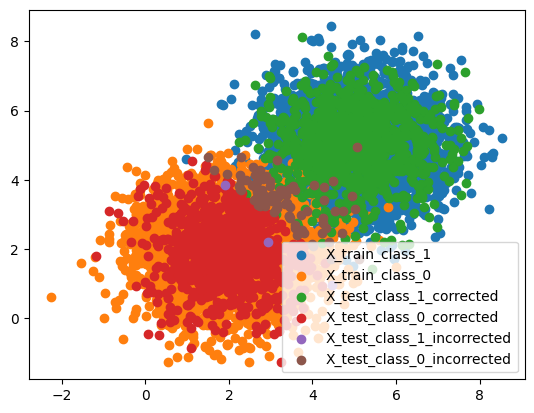

(2,)
(1943,)
(4021, 2)
(4036, 2)
(976, 2)
(878, 2)
(3, 2)
(86, 2)


In [7]:
##
# Construct a linear least square function:
#
beta = LLS(X_train, Y_train)

##
# Classify elements in the test set:
#
Yhat_test = LLS_classify(X_test, beta, 0.5)

##
# Get elements from training set:
#
X_train_class_1 = get_elements_from_training_set(X_train, Y_train, 1)
X_train_class_0 = get_elements_from_training_set(X_train, Y_train, 0)

##
# Get elements from test set:
#
X_test_class_1_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)
X_test_class_1_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)

##
# Compute the accuracy:
#
accuracy = compute_classifier_accuracy(X_test, Y_test, Yhat_test)
print(accuracy)

##
# Plot elements of sets:
#
fig, axs = plt.subplots()
axs.scatter(x = X_train_class_1[ : , 0], y = X_train_class_1[ : , 1], label = 'X_train_class_1')
axs.scatter(x = X_train_class_0[ : , 0], y = X_train_class_0[ : , 1], label = 'X_train_class_0')
axs.scatter(x = X_test_class_1_corrected[ : , 0], y = X_test_class_1_corrected[ : , 1],
            label = 'X_test_class_1_corrected')
axs.scatter(x = X_test_class_0_corrected[ : , 0], y = X_test_class_0_corrected[ : , 1],
            label = 'X_test_class_0_corrected')
axs.scatter(x = X_test_class_1_incorrected[ : , 0], y = X_test_class_1_incorrected[ : , 1],
            label = 'X_test_class_1_incorrected')
axs.scatter(x = X_test_class_0_incorrected[ : , 0], y = X_test_class_0_incorrected[ : , 1],
            label = 'X_test_class_0_incorrected')
axs.legend(loc = 'lower right')
plt.show()

##
# Sanity check:
#
print(beta.shape)
print(Yhat_test.shape)
print(X_train_class_1.shape)
print(X_train_class_0.shape)
print(X_test_class_1_corrected.shape)
print(X_test_class_0_corrected.shape)
print(X_test_class_1_incorrected.shape)
print(X_test_class_0_incorrected.shape)


### Problem 4

0.9711785898095728


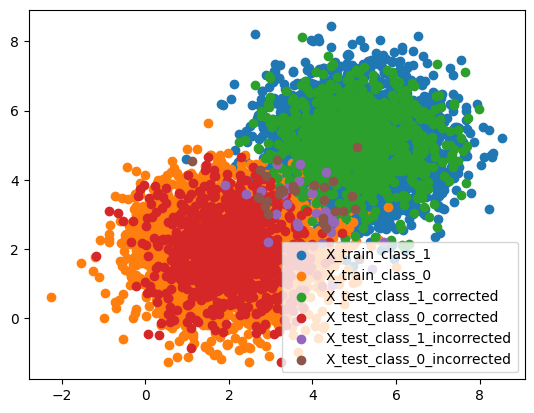

(2,)
(1943,)
(4021, 2)
(4036, 2)
(952, 2)
(935, 2)
(27, 2)
(29, 2)


In [8]:
##
# Construct a kD tree from the training set:
#
tree = cKDTree(X_train)

##
# Use the tree to classify the test set:
#
_ , indices = tree.query(X_test)
Yhat_test = Y_train[indices]

##
# Get elements from test set:
#
X_test_class_1_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)
X_test_class_1_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)

##
# Compute the accuracy:
#
accuracy = compute_classifier_accuracy(X_test, Y_test, Yhat_test)
print(accuracy)

##
# Plot elements of sets:
#
fig, axs = plt.subplots()
axs.scatter(x = X_train_class_1[ : , 0], y = X_train_class_1[ : , 1], label = 'X_train_class_1')
axs.scatter(x = X_train_class_0[ : , 0], y = X_train_class_0[ : , 1], label = 'X_train_class_0')
axs.scatter(x = X_test_class_1_corrected[ : , 0], y = X_test_class_1_corrected[ : , 1],
            label = 'X_test_class_1_corrected')
axs.scatter(x = X_test_class_0_corrected[ : , 0], y = X_test_class_0_corrected[ : , 1],
            label = 'X_test_class_0_corrected')
axs.scatter(x = X_test_class_1_incorrected[ : , 0], y = X_test_class_1_incorrected[ : , 1],
            label = 'X_test_class_1_incorrected')
axs.scatter(x = X_test_class_0_incorrected[ : , 0], y = X_test_class_0_incorrected[ : , 1],
            label = 'X_test_class_0_incorrected')
axs.legend(loc = 'lower right')
plt.show()

##
# Sanity check:
#
print(beta.shape)
print(Yhat_test.shape)
print(X_train_class_1.shape)
print(X_train_class_0.shape)
print(X_test_class_1_corrected.shape)
print(X_test_class_0_corrected.shape)
print(X_test_class_1_incorrected.shape)
print(X_test_class_0_incorrected.shape)


### Problem 5
Note: in this problem, I created 10 overlapping Gaussian distributions, each with a randomized mean and a randomized variance from 0 to 10.

(8057, 2)
(1943, 2)


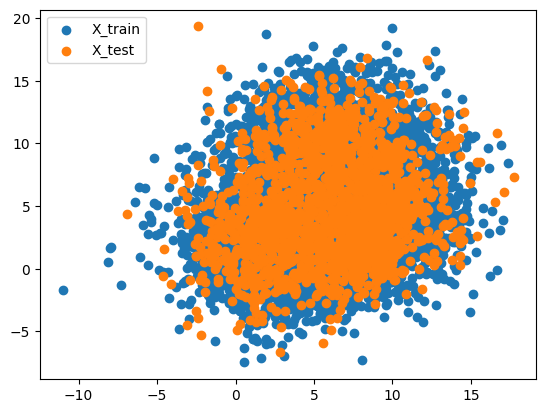

In [9]:
##
# Create 10 different overlapping Gaussian distributions:
#
seed = 28
np.random.seed(28)

means = [[x1, x2] for x1, x2 in zip(np.random.rand(10) * 10, np.random.rand(10) * 10)]
covs = [[[i, 0], [0, i]] for i in (np.random.rand(10) * 10)]
X = [np.random.multivariate_normal(mean, cov, 1000) for mean, cov in zip(means, covs)]

##
# Create X:
#
X = np.vstack(X)

##
# Create Y:
#
Y = np.zeros(10000)
Y[5000:] = 1

##
# Partition X and Y into training and test sets:
#
cutoff = 0.8
mask = np.random.rand(X.shape[0]) < cutoff
X_train = X[mask]
X_test = X[np.logical_not(mask)]

Y_train = Y[mask]
Y_test = Y[np.logical_not(mask)]

##
# Sanity check:
#
print(X_train.shape)
print(X_test.shape)
fig, axs = plt.subplots()
axs.scatter(x = X_train[ : , 0], y = X_train[ : , 1], label = 'X_train')
axs.scatter(x = X_test[ : , 0], y = X_test[ : , 1], label = 'X_test')
axs.legend()
plt.show()

0.6232629953679877


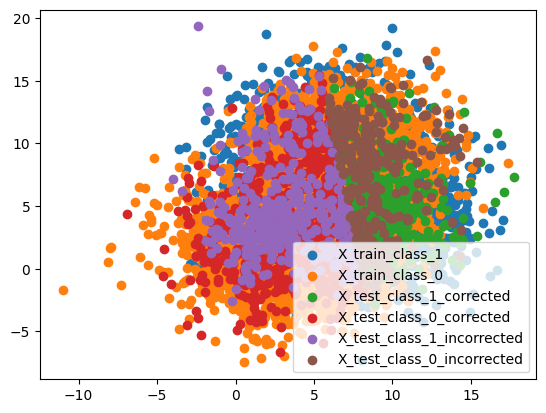

(2,)
(1943,)
(4022, 2)
(4035, 2)
(549, 2)
(662, 2)
(429, 2)
(303, 2)


In [10]:
##
# Perform linear classification:
#
beta = LLS(X_train, Y_train)
Yhat_test = LLS_classify(X_test, beta, 0.5)

##
# Get elements from training set:
#
X_train_class_1 = get_elements_from_training_set(X_train, Y_train, 1)
X_train_class_0 = get_elements_from_training_set(X_train, Y_train, 0)

##
# Get elements from test set:
#
X_test_class_1_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)
X_test_class_1_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)

##
# Compute the accuracy:
#
accuracy = compute_classifier_accuracy(X_test, Y_test, Yhat_test)
print(accuracy)

##
# Plot elements of sets:
#
fig, axs = plt.subplots()
axs.scatter(x = X_train_class_1[ : , 0], y = X_train_class_1[ : , 1], label = 'X_train_class_1')
axs.scatter(x = X_train_class_0[ : , 0], y = X_train_class_0[ : , 1], label = 'X_train_class_0')
axs.scatter(x = X_test_class_1_corrected[ : , 0], y = X_test_class_1_corrected[ : , 1],
            label = 'X_test_class_1_corrected')
axs.scatter(x = X_test_class_0_corrected[ : , 0], y = X_test_class_0_corrected[ : , 1],
            label = 'X_test_class_0_corrected')
axs.scatter(x = X_test_class_1_incorrected[ : , 0], y = X_test_class_1_incorrected[ : , 1],
            label = 'X_test_class_1_incorrected')
axs.scatter(x = X_test_class_0_incorrected[ : , 0], y = X_test_class_0_incorrected[ : , 1],
            label = 'X_test_class_0_incorrected')
axs.legend(loc = 'lower right')
plt.show()

##
# Sanity check:
#
print(beta.shape)
print(Yhat_test.shape)
print(X_train_class_1.shape)
print(X_train_class_0.shape)
print(X_test_class_1_corrected.shape)
print(X_test_class_0_corrected.shape)
print(X_test_class_1_incorrected.shape)
print(X_test_class_0_incorrected.shape)


0.6026762738033968


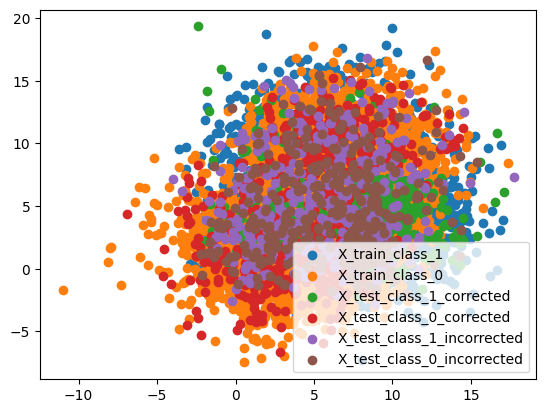

(2,)
(1943,)
(4022, 2)
(4035, 2)
(569, 2)
(602, 2)
(409, 2)
(363, 2)


In [11]:
##
# Perform kDTree's classification:
#
tree = cKDTree(X_train)

##
# Use the tree to classify the test set:
#
_ , indices = tree.query(X_test)
Yhat_test = Y_train[indices]

##
# Get elements from test set:
#
X_test_class_1_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)
X_test_class_1_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)

##
# Compute the accuracy:
#
accuracy = compute_classifier_accuracy(X_test, Y_test, Yhat_test)
print(accuracy)

##
# Plot elements of sets:
#
fig, axs = plt.subplots()
axs.scatter(x = X_train_class_1[ : , 0], y = X_train_class_1[ : , 1], label = 'X_train_class_1')
axs.scatter(x = X_train_class_0[ : , 0], y = X_train_class_0[ : , 1], label = 'X_train_class_0')
axs.scatter(x = X_test_class_1_corrected[ : , 0], y = X_test_class_1_corrected[ : , 1],
            label = 'X_test_class_1_corrected')
axs.scatter(x = X_test_class_0_corrected[ : , 0], y = X_test_class_0_corrected[ : , 1],
            label = 'X_test_class_0_corrected')
axs.scatter(x = X_test_class_1_incorrected[ : , 0], y = X_test_class_1_incorrected[ : , 1],
            label = 'X_test_class_1_incorrected')
axs.scatter(x = X_test_class_0_incorrected[ : , 0], y = X_test_class_0_incorrected[ : , 1],
            label = 'X_test_class_0_incorrected')
axs.legend(loc = 'lower right')
plt.show()

##
# Sanity check:
#
print(beta.shape)
print(Yhat_test.shape)
print(X_train_class_1.shape)
print(X_train_class_0.shape)
print(X_test_class_1_corrected.shape)
print(X_test_class_0_corrected.shape)
print(X_test_class_1_incorrected.shape)
print(X_test_class_0_incorrected.shape)